# Example: Analysis of a Synthetic Covered Call Positions on AMD
A covered call is a two-leg strategy in which equity, e.g., stock or an ETF, is purchased, and then call contracts are sold on a share-for-share basis against those shares. Profit and loss of a covered call position:

* The maximum profit of a covered call is achieved if the stock price is at or above the call's strike price at expiration.
* Losses occur in covered calls if the stock price declines below the breakeven point. In addition, there is also an _opportunity risk_ if the stock price rises above the effective selling price of the covered call.

### Learning objectives and tasks
The objective of this example is to familiarize students with the analysis of covered call positions, in this case on [Advanced Micro Devices, Inc.](https://www.amd.com/en.html), with the ticker symbol `AMD.`

## Setup
Set up the computational environment using the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites
Before doing anything else, we load the `AMD` options chain data before the market opens on `11-13-2024` (close) and save this data in the `dataset::DataFrame` variable. This data was downloaded [from Barchart.com](https://www.barchart.com/).

In [5]:
dataset = CSV.read(joinpath(_PATH_TO_DATA, "amd-options-exp-2024-12-20-monthly-20-strikes-stacked-11-14-2024.csv"), DataFrame)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type,Last Trade
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7,String15
1,40.0,0.7128,99.35,99.63,99.9,114.93,0,2,0.9952,1.6954,Call,9/20/24
2,45.0,0.677,94.4,94.65,94.9,109.69,0,53,0.99466,1.5446,Call,9/20/24
3,50.0,0.6411,89.2,89.55,89.9,98.65,0,9,0.99915,1.09,Call,11/8/24
4,55.0,0.6052,84.45,84.7,84.95,106.23,0,9,0.99345,1.2889,Call,10/1/24
5,60.0,0.5693,79.45,79.73,80.0,110.7,0,8,0.99276,1.1782,Call,10/4/24
6,65.0,0.5334,74.55,74.78,75.0,77.49,0,27,0.99096,1.1006,Call,11/4/24
7,70.0,0.4975,69.6,69.82,70.05,74.05,0,47,0.98892,1.0243,Call,11/6/24
8,75.0,0.4616,64.6,64.85,65.1,74.58,0,51,0.98777,0.9324,Call,11/7/24
9,80.0,0.4257,59.65,59.88,60.1,69.54,0,46,0.98648,0.8462,Call,11/7/24


 Let's set the parameters for `AMD` so we can use these data below:

In [7]:
DTE = 37.0; # days to expiration
Sₒ = 139.05; # AMD underlying share price USD/share, close 11/13/2024
Δt = (1/365); # Time step 1-trading day
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
number_of_points_per_day = 10; # number of levels per day
h = DTE*number_of_points_per_day; # levels in the binomial lattice
w = 0.3; # width parameter

## Task 1: Select a random call option from the dataset
In this task, we'll select call option contracts such that $S_{\circ}<K\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$, and we purchase the counter asset, in this case shares, from the market at $S_{\circ}$. Let's begin by filtering the contracts in the `dataset::DataFrame` to include only `call` contracts that obey the strike price constraint.

Save the filtered selection of `call` contracts in the `call_contracts::DataFrame` variable:

In [9]:
call_contracts = filter(:Type=>x->x == "Call", dataset) |> y -> filter(:Strike=> x-> (x > Sₒ && x ≤ (1+w)*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type,Last Trade
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7,String15
1,140.0,-0.005,7.0,7.1,7.2,7.09,1050,3314,0.52474,0.4019,Call,11/13/24
2,145.0,-0.0409,4.9,4.98,5.05,5.0,1835,9281,0.41592,0.4018,Call,11/13/24
3,150.0,-0.0768,3.35,3.4,3.45,3.35,5997,13700,0.31429,0.3976,Call,11/13/24
4,155.0,-0.1127,2.3,2.32,2.34,2.32,4830,13304,0.23438,0.4061,Call,11/13/24
5,160.0,-0.1486,1.57,1.58,1.58,1.58,3712,15870,0.17083,0.4133,Call,11/13/24
6,165.0,-0.1845,1.08,1.1,1.11,1.1,1214,10012,0.12475,0.424,Call,11/13/24
7,170.0,-0.2204,0.78,0.79,0.8,0.79,2907,12785,0.09237,0.4374,Call,11/13/24
8,175.0,-0.2563,0.59,0.6,0.61,0.59,1223,10293,0.07006,0.4534,Call,11/13/24
9,180.0,-0.2922,0.46,0.46,0.47,0.47,2586,13603,0.05562,0.4737,Call,11/13/24


Select a random contract from the `call_contracts::DataFrames` collection; this will be our second leg of the strangle. Save the data for this contract in the `call_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [11]:
call_leg_data = nrow(call_contracts) |> i-> call_contracts[rand(1:i),:] # fancy!

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type,Last Trade
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7,String15
8,175.0,-0.2563,0.59,0.6,0.61,0.59,1223,10293,0.07006,0.4534,Call,11/13/24


Next, build a [`MyAmericanCallContractModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) using the `call` contract data and store this contract model in the `call_contract_model::MyAmericanCallContractModel` variable. 
* To access data from the `DataFrameRow,` pass in the column name. For example, to get the strike price, you would say: `call_leg_data[:Strike].` For the premium value, use the midpoint value.

In [13]:
call_contract_model = build(MyAmericanCallContractModel, (
    K = call_leg_data[:Strike], # set the strike price from the random call contract
    premium = call_leg_data[:Mid], # set the premium value from the random call contract
    sense = -1, # we are short, i.e., we *sold* this contract so sense = -1 
    copy = 1));

Finally, let's build a model of the long call deep in the money (ITM) counter asset, i.e., the counter asset for our synthetic covered call. We sold a single call contract; so we need to own `100` shares of `AMD.` We do that _synthetically_ by buying a deep ITM call. 

In [15]:
my_leap_contract_model = let

    # Leap parameters - let's select a Δ ≈ 1 contract that expires in 2027
    # This contract has a Δ = 0.9838
    my_leap_model = build(MyAmericanCallContractModel, (
        K = 25, # strike price
        IV = 0.7879, # implied volatility on LEAP
        premium = 118.0, # set the premium (use the Mark)
        sense = 1,
        copy = 1
    ));
    
    # return
    my_leap_model;
end;

## Task 2: Analysis of the Profit, Loss, and Breakeven of the Synthetic Covered Call at Expiration
In this task, let's compute the breakeven point on this position and the profit and loss diagram for the synthetic covered call position at expiration. 

Let's start with the breakeven analysis. A synthetic covered call is a wide debit call vertical spread, where the long leg is deep in the money. Thus, we can use our standard approach to compute the breakeven of a composite contract.

### General case
The overall payoff of a general composite contract set $\mathcal{C}$ with `d`-legs is denoted as $\hat{V}(S(T),K_{1},\dots,K_{d})$ and given by:
$$
\begin{equation*}
\hat{V}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}V_{i}(S(T),K_{i})
\end{equation*}
$$
where $K_{i}$ denotes the strike price of contract $i\in\mathcal{C}$. The overall profit of the composite contract $\hat{P}$ is given by:
$$
\begin{equation*}
\hat{P}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}P_{i}(S(T),K_{i})
\end{equation*}
$$
where $\theta_{i}$ denotes the direction of contract $i$: if contract $i$ is short (sold), then $\theta_{i}=-1$, otherwise $\theta_{i}=1$, $n_{i}$ denotes the copy number of contract $i$, ${V}_{i}(S(T),K_{i})$ denotes the payoff of contract $i$, and $P_{i}(S(T),K_{i})$ denotes the profit of contract $i$. Finally, the profit for the contract of type $\star$ is given by:
$$
\begin{equation*}
P_{\star}(K,S(T)) = {V}_{\star}(K,S(T)) -  \mathcal{P}_{\star}(K,S(0))
\end{equation*}
$$
where $\mathcal{P}_{\star}(K,S(0))$ denotes the premium of contract $\star$, and ${V}_{\star}(K,S(T))$ denotes the payoff of contract $\star$ at expiration.

### Synthetic Covered Call
The synthetic covered call consists of a long and short call contract. Let index = `1` denote the short call contract, and index = `2` denote the long call contract and $K_{1}>S_{\circ}>K_{2}$. Then, the profit expression is given by:
$$
\begin{equation*}
\hat{P}(S(T),K_{1},K_{2}) = -1\cdot\left({V}^{(1)}_{c}(K_{1},S(T)) -  \mathcal{P}^{(1)}_{c}(K_{1},S(0))\right) + \left({V}^{(2)}_{c}(K_{2},S(T)) -  \mathcal{P}^{(2)}_{c}(K_{2},S(0))\right)
\end{equation*}
$$
which simplifies to:
$$
\hat{P}(S(T),K_{1},K_{2}) = (S_{T} - K_{2})^{+} - (S_{T} - K_{1})^{+} + \Delta\mathcal{P}
$$
where $(S_{T} - K_{\star})^{+} \equiv \max(S_{T} - K_{\star},0)$ and $\Delta\mathcal{P} = \left(\mathcal{P}_{c}^{(1)}(K_{1},S(0)) - \mathcal{P}_{c}^{(2)}(K_{2},S(0))\right)$. 

Let's compute the deal flow for different close prices at expiration scenarios.
* __Scenario 1 Maximum Profit__: When the underlying share price closes _above_ the short strike $S_{T}\geq{K}_{1}+\epsilon$, where $\epsilon$ is at least $\epsilon\geq{0.01}$, we recieve the maximum profit of $(K_{1} - K_{2}) + \Delta{\mathcal{P}}$ on the trade.
* __Scenario 2 Maximum Loss__: When the underlying share price closes _below_ the long strike $S_{T}\leq{K}_{2}-\epsilon$, where $\epsilon$ is at least $\epsilon\geq{0.01}$, we experience the maximum loss $\Delta\mathcal{P}$ on the trade.
* __Scenario 3 Breakeven__: We break even on the trade, i.e., $\hat{P} = 0$, when $S_{T} = B$, where $B = K_{2} - \Delta\mathcal{P}$.

In [17]:
max_profit, max_loss, B = let

    # setup
    K₁ = call_contract_model.K; # short strike
    K₂ = my_leap_contract_model.K; # long strike
    Δ𝒫 = (call_contract_model.premium - my_leap_contract_model.premium); # difference in premium

    # scenarios -
    max_profit = (K₁ - K₂) + Δ𝒫; # max profit case
    max_loss = Δ𝒫; # max loss, both contracts expire worthless 
    B = K₂ - Δ𝒫;

    # return
    max_profit, max_loss, B
end;

In [18]:
println("Max profit = $(max_profit), max loss = $(max_loss) and breakeven = $(B) USD/share")

Max profit = 32.599999999999994, max loss = -117.4 and breakeven = 142.4 USD/share


### Visualize
Now that we have analytically computed the maximum profit, maximum loss, and breakeven values, let's visualize the profit diagram at expiration for the synthetic covered call. To do this, build an array of share prices at expiration and save this in the `share_price_array::Array{Float64,1}` variable. 
* We'll look at a range between the short strike $w\cdot{K_{2}}$ and $\left(2-w\right)\cdot{K}_{1}$, where $w$ is a width parameter $0<w<1$ that we specify.

In [20]:
share_price_array = let

    w = 0.80; # width of range to explore. Adjust me to see what happens
    number_of_steps = 1001; # leave me alone!
    K₁ = call_contract_model.K;
    K₂ = my_leap_contract_model.K;
    
    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((w)*K₂,stop = (1+(1-w))*K₁, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the short strangle. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments, the contract models as an array and the share price array.

* The `profit_array` will be a `1001`$\times$ `4` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S_{T}$ values, column `2` holds the profit for the short call contract, column `3` holds the profit for the long call, and column `4` holds the overall profit for the composite trade.

In [22]:
profit_array = profit([call_contract_model, my_leap_contract_model], share_price_array);

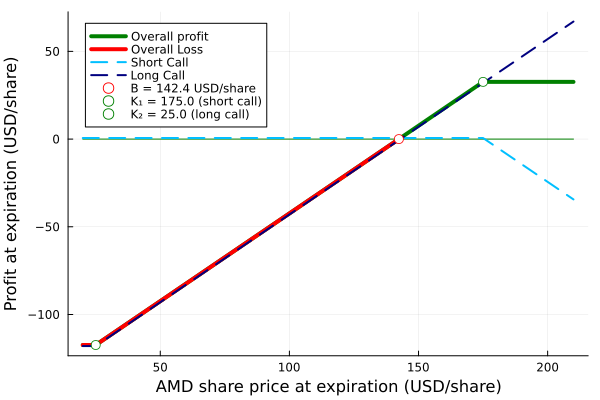

In [23]:
let
    # initialize 
    N = length(profit_array[:,1]); # how many steps do we have?
    BEL = zeros(N);
    K₁ = call_contract_model.K;
    K₂ = my_leap_contract_model.K;
    # Sₚ = my_equity_model.purchase_price

    # SPL_vertical = range(-100,stop=100,length=N) |> collect;
    # SPL_horizontal = Sₒ*ones(N);
    # STRIKE_horizontal = K;

    # setup the coloring -
    profit_idx = findall(>(0), profit_array[:,end])
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    plot(profit_array[:,1],profit_array[:,end], lw=4, c=:green, label="Overall profit")
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Overall Loss", c=:red)
    plot!(profit_array[:,1], BEL, c=:green, lw=1, label="")
    plot!(profit_array[:,1],profit_array[:,2], lw=2, c=:deepskyblue1, label="Short Call", ls=:dash)
    plot!(profit_array[:,1],profit_array[:,3], lw=2, c=:navy, label="Long Call", ls=:dash)
    
    # scatter!([Sₚ], [0], ms=5, c=:navy, msc=:navy, ls=:dash, label="Sₚ = $(Sₚ) USD/share")
    scatter!([B], [0], ms=5, c=:white, msc=:red, ls=:dash, label="B = $(round(B, digits=4)) USD/share")
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short call)", msc=:green, c=:white)
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long call)", msc=:green, c=:white)
    # scatter!([max_profit_intersection],[max_profit], ms=5, label = "Opportunity loss = $(max_profit_intersection) USD/share", msc=:navy, c=:white)
    
    xlabel!("AMD share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit at expiration (USD/share)", fontsize=18)
end

## Task 3: Probability of Outcomes
In this task, let's compute the probability of observing exit scenarios for our covered call position on `AMD.` We'll consider three scenarios from above: the maximum profit, the maximum loss, and the breakeven case. To start, we need to build a mechanism to simulate future share prices; we'll use geometric Brownian motion to do this.

### Geometric Brownian Motion (GBM)
Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data.

In [26]:
model, σ̄ = let

    # Step 1: get the implied volatility 
    σ̄ = call_leg_data[:IV]; # we have two contracts, but do I care about the long call?

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate,
        σ = σ̄
    ));

    model, σ̄
end;

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `MU` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop-time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}\cdot\Delta{t}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

In [28]:
endpoint = let
    number_of_samples = 25000;
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model emits a LogNormal share price distribution. Fit a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable

In [30]:
d_gbm = fit_mle(LogNormal, endpoint);

### Cumulative distribution
Next, estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the geometric Brownian motion and implied volatility share price distributions. 
We can query the cumulative distribution function $F_{S}(\star)$ using for the projected geometric Brownian motion distribution `d_gbm` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

#### Refresher
Before starting the calculations, let's quickly refresh our knowledge of what the cumulative probability distribution function tells us. The cumulative distribution function of a real-valued random variable $X$ (this is share price at expiration in our case) is given by:
$$
P(X\leq{x}) = F_{X}(x)
$$
that is, the probability that we see a value for the random variable $X$ less than or equal to the specified value $x$ is the cumulative distribution function evaluated at $x$. Alternatively, $P(X>x)$ is given by:
$$
P(X>{x}) = 1 - F_{X}(x)
$$
Lastly, the probability that $X$ (share price at expiration) lies in the interval $(a,b]$, where $a < b$ is given by:
$$
P(a < X \leq b) = F_{X}(b) - F_{X}(a)
$$
In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

#### Visualize
`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `AMD` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` model:

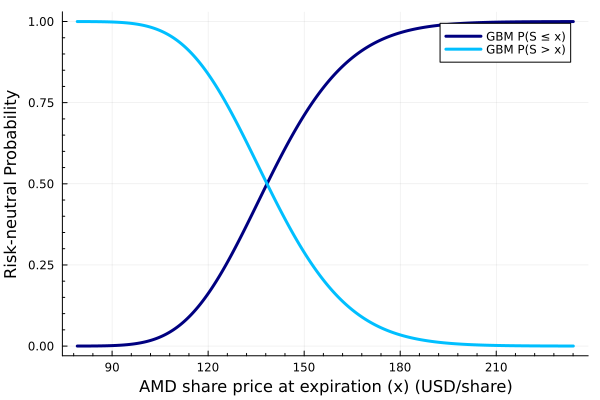

In [33]:
let
    number_of_samples = length(endpoint);
    X = Array{Float64,2}(undef, number_of_samples, 2);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint)
        push!(S,endpoint[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)")

    xlabel!("AMD share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Risk-neutral Probability", fontsize=18);
end

__Scenario 1: Maximum profit__. In this scenario, the underlying share price closes _above_ the short strike $S_{T}\geq{K}_{1}+\epsilon$, where $\epsilon$ is at least $\epsilon\geq{0.01}$ USD/share. The probability of this scenario occurring is given by $P(S_{T}>K_{1}) = 1 - F_{S}\left(K_{1}\right)$.

In [35]:
p_max_profit_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    K₁ = call_contract_model.K;
    p_max_profit_gbm = nothing;

    # compute P(S > K₁) for the GBM model
    p_max_profit_gbm = 1 - cdf(d_gbm,K₁);

    # return data -
    p_max_profit_gbm
end;

In [36]:
println("Scenario 1: Probability maximum profit GBM = $(p_max_profit_gbm)")

Scenario 1: Probability maximum profit GBM = 0.052165353111059076


__Scenario 2 Maximum Loss__: When the underlying share price closes _below_ the long strike $S_{T}\leq{K}_{2}-\epsilon$, where $\epsilon$ is at least $\epsilon\geq{0.01}$, we experience the maximum loss. The probability of this scenario occurring is given by $P(S_{T}\leq{K_{2}}-\epsilon) = F_{S}\left(K_{2}-\epsilon\right)$.

In [38]:
p_max_loss_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_max_loss_gbm = nothing;
    K₂ = my_leap_contract_model.K;

    # compute the probability P(S_low < S_{T} ≤ S_high) for the GBM and IV
    p_max_loss_gbm = cdf(d_gbm,K₂ - ϵ)

    # return data -
    p_max_loss_gbm
end;

In [39]:
println("Scenario 2: Probability max loss GBM = $(p_max_loss_gbm)")

Scenario 2: Probability max loss GBM = 1.1100345612061343e-32


__Scenario 3 Breakeven__: We break even on the trade, i.e., $\hat{P} = 0$, when $S_{T} = B$, where $B = K_{2} - \Delta\mathcal{P}$. Let's compute the probability that we at least breakeven on the trade, i.e., $P(S_{T} > B) = 1 - F_{S}(B)$.

In [41]:
p_breakeven = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_breakeven = nothing;

    # compute the probability P(S_T > B)
    p_breakeven = 1 - cdf(d_gbm, B)

    # return data -
    p_breakeven
end;

In [42]:
println("Scenario 3: Probability of breakeven GBM = $(p_breakeven)")

Scenario 3: Probability of breakeven GBM = 0.4217769916723575


### Discussion
* With a long-term synthetic covered call, do we care if we have a low probability of achieving maximum profit?
* Should we put the short strike _above or below_ the breakeven price of the _long_ share replacement leg? (Think about what happens if we need to get the shares).

In [79]:
breakeven_leap_contract = let
    K₂ = my_leap_contract_model.K;
    premium_long_call = my_leap_contract_model.premium;
    breakeven_leap_contract = K₂ + premium_long_call;

    # return -
    breakeven_leap_contract;
end

143.0

Is the short strike greater than the breakeven on the long call leg?

In [81]:
short_strike_placed_correctly = let
    K₁ = call_contract_model.K;
    short_strike_placed_correctly = (K₁ ≥ breakeven_leap_contract)
end

true

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.